In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load the CSV
df = pd.read_csv('player_sample.csv')
df.fillna(0, inplace=True)
df.head()


,Age,Previous App Purchases,Price
0,37,218,6.0
1,34,247,6.0
2,19,15,4.0
3,32,235,7.0
4,19,15,2.5


In [16]:
missing_count = df.isna().sum()
missing_count

Age                       0
Previous App Purchases    0
Price                     0
dtype: int64

In [17]:
# Convert the Price column to numeric safely
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df.describe()

,Age,Previous App Purchases,Price
count,10000.000000,10000.000000,10000.000000
mean,36.588400,187.724300,1.811900
std,15.647053,81.677551,3.200069
min,11.000000,0.000000,0.000000
25%,27.000000,121.000000,0.000000
50%,32.000000,226.000000,0.000000
75%,39.000000,246.000000,2.500000
max,75.000000,312.000000,12.000000


## Part I Prescribing Prices

### 1. Suppose that Monteviu wishes to offer a single price for all players. Based on the data and the prescripCve analyCcs tools that we saw in class, propose a price that maximizes the expected revenue considering the total player base (i.e., 2,000,000).

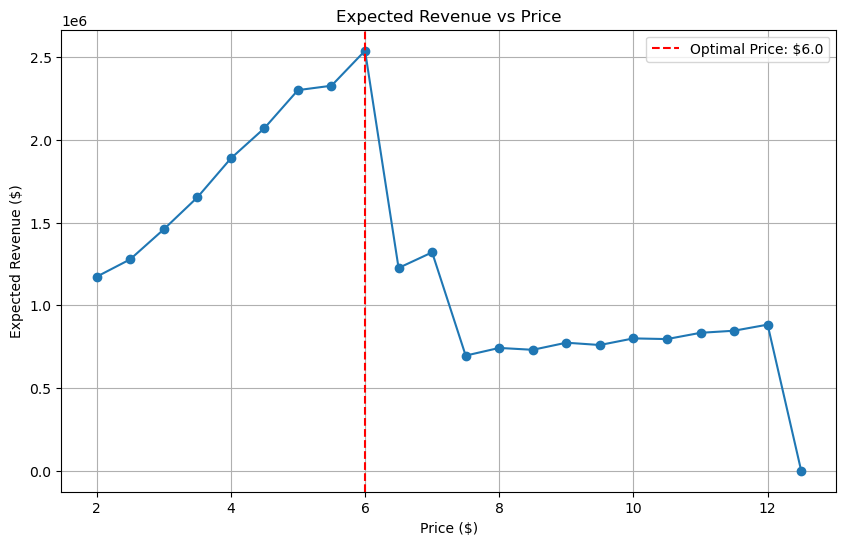

✅ Optimal Price: $6.00
💰 Max Expected Revenue: $2,539,200.00


In [18]:
# There is no sample including price above 12, so assume impossible
price_range = np.arange(2, 13, 0.5)
revenues = []
player_base = 2_000_000  # total players

for p in price_range:
    purchase_prob = (df['Price'] >= p).mean()
    revenue = purchase_prob * p * player_base
    revenues.append(revenue)

# Best price
optimal_price = price_range[np.argmax(revenues)]
max_revenue = max(revenues)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(price_range, revenues, marker='o')
plt.title("Expected Revenue vs Price")
plt.xlabel("Price ($)")
plt.ylabel("Expected Revenue ($)")
plt.grid(True)
plt.axvline(optimal_price, color='red', linestyle='--', label=f'Optimal Price: ${optimal_price}')
plt.legend()
plt.show()

print(f"✅ Optimal Price: ${optimal_price:.2f}")
print(f"💰 Max Expected Revenue: ${max_revenue:,.2f}")

### 2. Suppose now that Monteviu can offer a different price per player. While a player is in-game, Monteviu observes the player demographics and can select a personalized price they will experience accordingly. Based on your predicCve and prescripCve knowledge from the MMA courses and supply chain opCmizaCon, develop an efficient mechanism2 for personalized pricing that maximizes revenue. What insights do you obtain in this mechanism, i.e., can prices change significantly per person? Moreover, what is the increase in expected revenue compared to the single-price opCon?


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

# ---------- 2.  K‑means with 3 clusters ----------
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
df["cluster"] = kmeans.fit_predict(X_scaled)

# ---------- 3.  quick summaries ----------
# size of each cluster
print("\nCluster sizes:")
print(df["cluster"].value_counts().sort_index())

# centroids back‑transformed to original scale
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids_original, columns=df.columns.drop("cluster"))
centroid_df["cluster"] = centroid_df.index
print("\nCluster centroids (original scale):")
print(centroid_df)


Cluster sizes:
cluster
0    1200
1    6732
2    2068
Name: count, dtype: int64

Cluster centroids (original scale):
         Age  Previous App Purchases     Price  cluster
0  17.443333               14.402500  1.178333        0
1  31.401070              239.559566  1.738414        1
2  64.584139              119.557544  2.418762        2


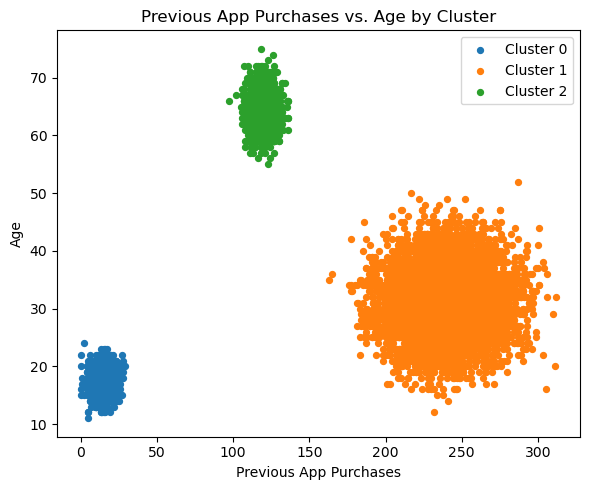

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Assume df with numeric features and "cluster" labels already exists
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("cluster")  # exclude label from candidates


for x_col, y_col in combinations(['Previous App Purchases', 'Age', 'Price'], 2):
    plt.figure(figsize=(6, 5))
    for cl in np.unique(df["cluster"]):
        mask = df["cluster"] == cl
        plt.scatter(
            df.loc[mask, x_col],
            df.loc[mask, y_col],
            label=f"Cluster {cl}",
            s=18,
        )
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{x_col} vs. {y_col} by Cluster")
    plt.legend()
    plt.tight_layout()
    plt.show()
    break


Optimal price per cluster
  • Cluster 0:  price = $2.00   revenue = $240,000
  • Cluster 1:  price = $6.00   revenue = $2,011,200
  • Cluster 2:  price = $12.00   revenue = $883,200


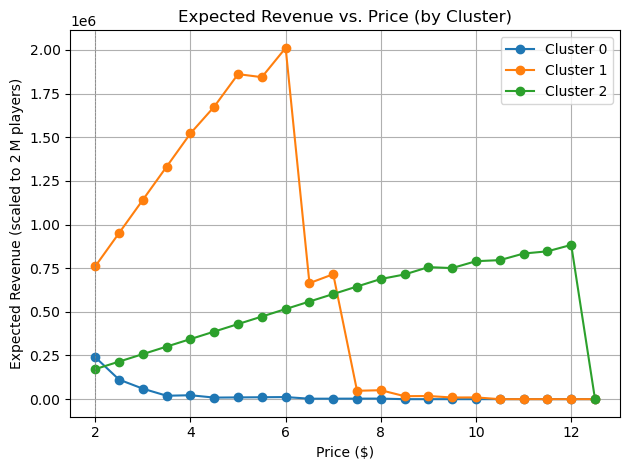

In [21]:
import numpy as np
import matplotlib.pyplot as plt

price_range   = np.arange(2, 12.5 + 0.5, 0.5)
player_base   = 2_000_000
clusters      = sorted(df["cluster"].unique())


best_price   = {}
best_revenue = {}

for c in clusters:
    sub = df[df["cluster"] == c]                  # rows in this cluster
    weight = len(sub) / len(df)                   # share of total population
    cluster_size = player_base * weight           # scale to full player base

    rev_curve = []
    for p in price_range:
        purchase_prob = (sub["Price"] >= p).mean()
        revenue       = purchase_prob * p * cluster_size
        rev_curve.append(revenue)

    # save the optimum for this cluster
    idx_best         = int(np.argmax(rev_curve))
    best_price[c]    = price_range[idx_best]
    best_revenue[c]  = rev_curve[idx_best]

    plt.plot(price_range, rev_curve, marker="o", label=f"Cluster {c}")


print("Optimal price per cluster")
for c in clusters:
    print(f"  • Cluster {c}:  "
          f"price = ${best_price[c]:.2f}   "
          f"revenue = ${best_revenue[c]:,.0f}")

plt.title("Expected Revenue vs. Price (by Cluster)")
plt.xlabel("Price ($)")
plt.ylabel("Expected Revenue (scaled to 2 M players)")
plt.axvline(best_price[clusters[0]], color="grey", ls="--", lw=0.5)  # first v‑line as guide
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
total_with_personalized_price = 0
for c in clusters:
  total_with_personalized_price += best_revenue[c]
print(f"Total revenue with personalized price: ${total_with_personalized_price:,.0f}")


Total revenue with personalized price: $3,134,400


In [23]:
revenue_lift = total_with_personalized_price - max_revenue
print(f"Incremental revenue from personalised pricing: ${revenue_lift:,.0f}")

Incremental revenue from personalised pricing: $595,200


```text
Using a single, event‑wide price, the optimiser settles on $6.00, which every player can either accept or reject; this “one‑size” strategy produces an expected two‑day revenue of $2,539,200. 
When we segment the audience into three behavioural clusters and give each group its own optimal price—$12.00 for high‑WTP players, $6.00 for the mid‑range, and $2.00 for price‑sensitive users—the combined revenue rises to $3,134,400.
That is an extra $595,200, or about 23% uplift over the best single‑price option.
In practical terms, prices change only at the segment level (a $10 spread from $2 to $12), so no individual faces a wildly different offer, yet the publisher still captures a meaningful slice of additional surplus by matching prices more closely to each cluster’s willingness to pay.


## Part II – Discounting

In [24]:

from  scipy.optimize import minimize_scalar

# keep your constants
STEP, MAXD = 5, 80        # % step & cap
CAP_DAY    = 10_000       # ≤10 000 accepts per day
DAYS       = 2            # 2‑day event
CAP_TOTAL  = CAP_DAY * DAYS

# ---------------- helper: one cluster, one base price -----------------
def cluster_offer(sub_df, base):
    """
    sub_df : DataFrame for ONE cluster (numeric features + 'Price')
    base   : candidate base price
    returns accepted_cnt, revenue, willing_cnt
    """
    req   = 100 * (1 - sub_df["Price"] / base)
    disc  = np.clip(np.ceil(req / STEP) * STEP, 0, MAXD)
    price = base * (1 - disc / 100)

    willing_mask = sub_df["Price"] >= price
    willing_cnt  = willing_mask.sum()

    # take up to the global cap, highest revenue first
    accepted_idx = (
        sub_df.loc[willing_mask]
              .assign(disc_price=price[willing_mask])
              .nlargest(CAP_TOTAL, "disc_price")
              .index
    )

    revenue      = price[accepted_idx].sum()
    accepted_cnt = len(accepted_idx)
    return accepted_cnt, revenue, willing_cnt

# ---------------- loop over clusters ----------------------------------
cluster_results = []

for c, sub in df.groupby("cluster"):
    # upper bound for this slice (like before)
    upper = sub["Price"].max() / 0.20

    # optimiser: maximise revenue (= minimise negative revenue)
    opt = minimize_scalar(
        lambda b: -cluster_offer(sub, b)[1],
        bounds=(5, upper), method="bounded"
    )

    base_price = opt.x
    accepted, revenue, willing = cluster_offer(sub, base_price)

    cluster_results.append({
        "cluster"        : c,
        "best_base_price": round(base_price, 2),
        "willing"        : int(willing),
        "accepted"       : accepted,
        "revenue"        : round(revenue, 0)
    })



### (a) the booster pack base price for the duration of the event;

In [25]:
summary = pd.DataFrame(cluster_results)
print(summary.to_string(index=False))
print(f"\nTotal revenue from cluster pricing : ${summary['revenue'].sum():,.0f}")


 cluster  best_base_price  willing  accepted  revenue
       0              8.0      600       600   1387.0
       1             20.0     1902      1902  11703.0
       2             40.0      430       430   4966.0

Total revenue from cluster pricing : $18,056


### (b) the personalized discount to be offered to each player to maximize expected revenues.

In [26]:

list_price_map = summary.set_index("cluster")["best_base_price"].to_dict()

# -------------------------------------------------
df["list_price"] = df["cluster"].map(list_price_map)

df["cluster_discount"] = df["Price"]/df["list_price"]

# quick sanity check
print(df[["cluster", "Price", "list_price","cluster_discount"]])


      cluster  Price  list_price  cluster_discount
0           1    6.0        20.0            0.3000
1           1    6.0        20.0            0.3000
2           0    4.0         8.0            0.5000
3           1    7.0        20.0            0.3500
4           0    2.5         8.0            0.3125
...       ...    ...         ...               ...
9995        1    0.0        20.0            0.0000
9996        1    0.0        20.0            0.0000
9997        1    0.0        20.0            0.0000
9998        2    0.0        40.0            0.0000
9999        2   12.0        40.0            0.3000

[10000 rows x 4 columns]


### Discuss your strategy and soluCon in detail, jusCfying your assumpCons and reporCng insights and quanCtaCve findings.

```text
We first segment the audience into three data‑driven clusters, then treat each cluster as its own “mini‑market.” For a candidate list price within a cluster, we calculate the smallest coupon (rounded up to the nearest five‑percent step and never deeper than an 80% cut) that would bring every player’s willingness‑to‑pay above the offer. We iterate over plausible list prices and keep the one that maximises expected revenue while ensuring the event can fulfil demand under its 10,000‑accepts‑per‑day capacity. That chosen list price becomes the posted price for everyone in the cluster—so prices vary across clusters but stay identical for players inside the same group, preserving transparency. Compared with a single uniform price, this scheme lets higher‑value clusters keep a near‑full‑price ticket, gives price‑sensitive clusters a steeper markdown, and systematically captures more of the spending capacity spread across the player base.


### 2. How does your strategy compare to using a unique discount (i.e., single-price strategy)for the duraCon of the event, both in terms of revenue and realized demand?



In [28]:
# ---------------------------------------------------------------
# Single‑price sweep for Ninja Crush Week
# ---------------------------------------------------------------

BASE_PRICE = 10        # use the same base price you found optimal above
FLAT_STEPS = range(0, 85, 5)   # 0%, 5%, …, 80%

CAP_TOTAL  = 10_000 * 2        # ≤20 000 acceptances across the two days

results = []

for D in FLAT_STEPS:
    ticket_price = BASE_PRICE * (1 - D / 100)          # everyone sees this price

    willing_mask = df["Price"] >= ticket_price         # who can afford it?
    willing_cnt  = willing_mask.sum()

    # honour the 20 000 total‑acceptances cap
    accepted_cnt = min(willing_cnt, CAP_TOTAL)
    revenue      = accepted_cnt * ticket_price

    results.append({"discount_%": D,
                    "ticket_price": ticket_price,
                    "willing": int(willing_cnt),
                    "accepted": int(accepted_cnt),
                    "revenue": revenue})

# convert to a DataFrame for easy viewing / sorting
flat_df = pd.DataFrame(results)


# -----------------------------------------------
# grab the row with the highest revenue
best_row = flat_df.loc[flat_df["revenue"].idxmax()]

best_discount = best_row["discount_%"]          # % off
best_price    = best_row["ticket_price"]        # $ each buyer pays
best_willing  = best_row["willing"]             # players who could afford it
best_accepted = best_row["accepted"]            # buyers actually served
best_revenue  = best_row["revenue"]             # two‑day revenue
print("single-price strategy")
print(f"🏆  Best flat discount : {best_discount:>2.0f}%")
print(f"    Ticket price      : ${best_price:,.2f}")
print(f"    Willing buyers    : {best_willing:,}")
print(f"    Accepted buyers   : {best_accepted:,}")
print(f"    Two‑day revenue   : ${best_revenue:,.0f}")



single-price strategy
🏆  Best flat discount : 40%
    Ticket price      : $6.00
    Willing buyers    : 2,116.0
    Accepted buyers   : 2,116.0
    Two‑day revenue   : $12,696


```text
Using three cluster‑specific prices outperforms a single flat discount on both money and reach. With targeted list prices the event converts 2,932 buyers and earns $18,056, whereas the best one‑price offer (40% off, $6 for everyone) draws 2,116 buyers and brings in $12,696. In other words, segmentation admits roughly 40% more customers and lifts expected revenue by about 42%, because each cluster pays a ticket price that is tight to its own willingness‑to‑pay instead of forcing all players into the same $6 bracket.
